In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from keras.models import load_model

Using TensorFlow backend.


Total Data : 52338
Bukan Dewasa : 26192
Dewasa : 26146


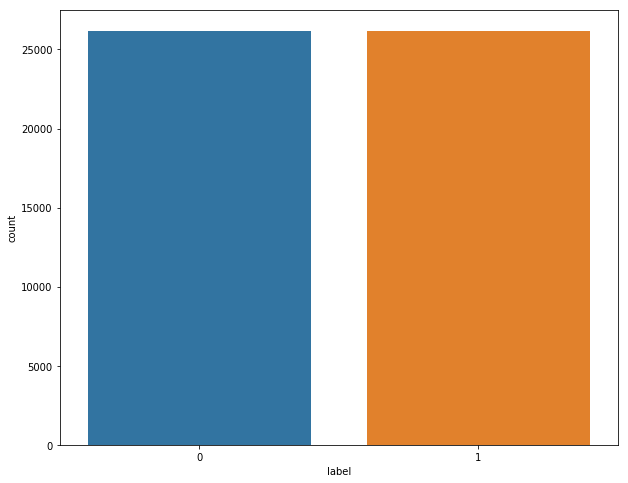

In [4]:
data = pd.read_excel("/content/drive/Shared drives/Riset Kolaborasi Dosen Mahasiswa 2019/FILTER KONTEN DEWASA/Code V5/combineSSL (1).xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [0]:
# Splitting Data
text = data['tweet'].values
label = data['label'].values
data_train, data_test, label_train, label_test = train_test_split(text, label, test_size=0.5, random_state=42)
data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size= 0.5, random_state=42)

In [0]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 256 #penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 10 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2)

In [0]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 2)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 2)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 2)

In [0]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class)
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class)
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [0]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [10]:
model1 = get_model1(X_train, Y_train)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 128)           5210752   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 5,342,594
Trainable params: 5,342,594
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# training model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))


Train on 26169 samples, validate on 13085 samples
Epoch 1/10
26169/26169 [==============================] - 21s 811us/step - loss: 0.4135 - acc: 0.8020 - val_loss: 0.1289 - val_acc: 0.9604
Epoch 2/10
26169/26169 [==============================] - 15s 590us/step - loss: 0.0543 - acc: 0.9855 - val_loss: 0.0544 - val_acc: 0.9844
Epoch 3/10
26169/26169 [==============================] - 15s 585us/step - loss: 0.0237 - acc: 0.9940 - val_loss: 0.0648 - val_acc: 0.9824
Epoch 4/10
26169/26169 [==============================] - 15s 582us/step - loss: 0.0130 - acc: 0.9969 - val_loss: 0.0606 - val_acc: 0.9835
Epoch 5/10
26169/26169 [==============================] - 15s 587us/step - loss: 0.0090 - acc: 0.9984 - val_loss: 0.0656 - val_acc: 0.9819
Epoch 6/10
26169/26169 [==============================] - 15s 577us/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0687 - val_acc: 0.9833
Epoch 7/10
26169/26169 [==============================] - 15s 583us/step - loss: 0.0072 - acc: 0.9985 - val_loss: 0

In [12]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model1, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model1, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model1, X_val, label_val)

Evaluasi Data Test
Accuracy: 98.13 %
Precision: 98.03 %
Recall: 98.23 %
Evaluasi Data Train
Accuracy: 99.92 %
Precision: 99.93 %
Recall: 99.91 %
Evaluasi Data Validation
Accuracy: 98.27 %
Precision: 98.17 %
Recall: 98.35 %


In [0]:
def get_model2(X, Y):
    model = Sequential()
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [14]:
model2 = get_model2(X_train, Y_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 58, 128)           5210752   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 58, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 5,342,594
Trainable params: 5,342,594
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# training model
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 26169 samples, validate on 13085 samples
Epoch 1/10
26169/26169 [==============================] - 20s 774us/step - loss: 0.4460 - acc: 0.7764 - val_loss: 0.1438 - val_acc: 0.9583
Epoch 2/10
26169/26169 [==============================] - 18s 699us/step - loss: 0.0748 - acc: 0.9804 - val_loss: 0.0553 - val_acc: 0.9854
Epoch 3/10
26169/26169 [==============================] - 18s 700us/step - loss: 0.0386 - acc: 0.9901 - val_loss: 0.0593 - val_acc: 0.9842
Epoch 4/10
26169/26169 [==============================] - 19s 717us/step - loss: 0.0260 - acc: 0.9931 - val_loss: 0.0636 - val_acc: 0.9824
Epoch 5/10
26169/26169 [==============================] - 19s 713us/step - loss: 0.0169 - acc: 0.9958 - val_loss: 0.0598 - val_acc: 0.9835
Epoch 6/10
26169/26169 [==============================] - 18s 703us/step - loss: 0.0114 - acc: 0.9970 - val_loss: 0.0689 - val_acc: 0.9828
Epoch 7/10
26169/26169 [==============================] - 18s 707us/step - loss: 0.0097 - acc: 0.9979 - val_loss: 0.

In [16]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model2, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model2, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model2, X_val, label_val)

Evaluasi Data Test
Accuracy: 97.60 %
Precision: 97.79 %
Recall: 97.40 %
Evaluasi Data Train
Accuracy: 99.90 %
Precision: 99.89 %
Recall: 99.91 %
Evaluasi Data Validation
Accuracy: 97.70 %
Precision: 97.89 %
Recall: 97.45 %


In [0]:
def get_model3(X, Y):
    model = Sequential()
    model.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen, embeddings_initializer = initializer))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [18]:
model3 = get_model3(X_train, Y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 64)            2605376   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 58, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,638,530
Trainable params: 2,638,530
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 26169 samples, validate on 13085 samples
Epoch 1/10
26169/26169 [==============================] - 21s 795us/step - loss: 0.5443 - acc: 0.7137 - val_loss: 0.2619 - val_acc: 0.9149
Epoch 2/10
26169/26169 [==============================] - 19s 718us/step - loss: 0.1479 - acc: 0.9546 - val_loss: 0.0727 - val_acc: 0.9816
Epoch 3/10
26169/26169 [==============================] - 19s 711us/step - loss: 0.0512 - acc: 0.9865 - val_loss: 0.0571 - val_acc: 0.9841
Epoch 4/10
26169/26169 [==============================] - 18s 700us/step - loss: 0.0310 - acc: 0.9917 - val_loss: 0.0541 - val_acc: 0.9847
Epoch 5/10
26169/26169 [==============================] - 18s 705us/step - loss: 0.0230 - acc: 0.9943 - val_loss: 0.0568 - val_acc: 0.9846
Epoch 6/10
26169/26169 [==============================] - 19s 710us/step - loss: 0.0163 - acc: 0.9957 - val_loss: 0.0663 - val_acc: 0.9817
Epoch 7/10
26169/26169 [==============================] - 18s 707us/step - loss: 0.0127 - acc: 0.9971 - val_loss: 0.

In [20]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model3, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model3, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model3, X_val, label_val)


Evaluasi Data Test
Accuracy: 98.28 %
Precision: 98.17 %
Recall: 98.39 %
Evaluasi Data Train
Accuracy: 99.89 %
Precision: 99.88 %
Recall: 99.90 %
Evaluasi Data Validation
Accuracy: 98.46 %
Precision: 98.31 %
Recall: 98.58 %


In [0]:
def get_model4(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(64, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [22]:
model4 = get_model4(X_train, Y_train)
history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 58, 64)            2605376   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 2,638,530
Trainable params: 2,638,530
Non-trainable params: 0
_________________________________________________________________
None
Train on 26169 samples, validate on 13085 samples
Epoch 1/10
26169/26169 [==============================] - 17s 644us/step - loss: 0.5114 - acc: 0.7277 - val_loss: 0.2576 - val_acc: 0.9242
Epoch 2/10
26169/26169 [==============================] - 15s 581us/step - loss: 0.1124 - acc: 0.9711 - val_loss: 0.0683 - val_acc: 0.9823
Epoch 3/10
26169/26169 [=================

In [23]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model4, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model3, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model4, X_val, label_val)

Evaluasi Data Test
Accuracy: 98.23 %
Precision: 98.42 %
Recall: 98.04 %
Evaluasi Data Train
Accuracy: 99.89 %
Precision: 99.88 %
Recall: 99.90 %
Evaluasi Data Validation
Accuracy: 98.31 %
Precision: 98.33 %
Recall: 98.26 %
